In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
folder_benign_train = '/content/gdrive/MyDrive/Colab Notebooks/input/data/train/benign'
folder_malignant_train = '/content/gdrive/MyDrive/Colab Notebooks/input/data/train/malignant'

folder_benign_test = '/content/gdrive/MyDrive/Colab Notebooks/input/data/test/benign'
folder_malignant_test = '/content/gdrive/MyDrive/Colab Notebooks/input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [5]:
# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

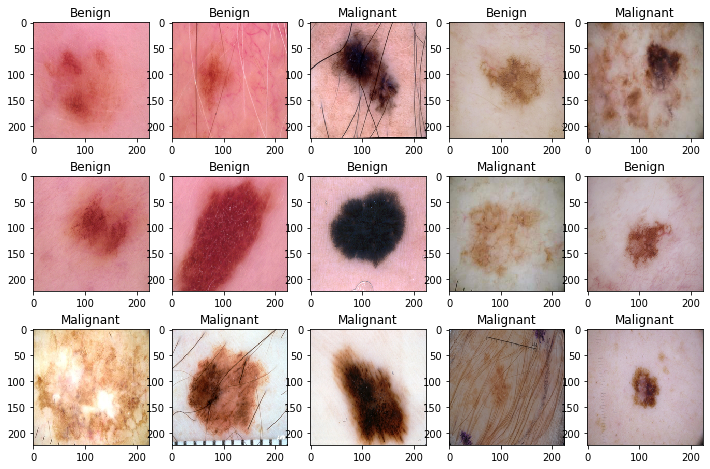

In [6]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [7]:
#Categorical Labels

y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [8]:
#Normalization
#Normalize all Values of the pictures by dividing all the RGB values by 255

# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [9]:
# Model Building

In [10]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2, init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape, activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-7)

In [11]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 32

In [15]:
model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           

In [16]:
history = model. (X_train, y_train, validation_split=0.2, epochs= epochs, batch_size= batch_size, verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/50
66/66 [==============================] - 8s 97ms/step - loss: 1.2956 - accuracy: 0.5263 - val_loss: 0.6568 - val_accuracy: 0.5814
Epoch 2/50
66/66 [==============================] - 5s 74ms/step - loss: 0.9229 - accuracy: 0.5655 - val_loss: 0.6399 - val_accuracy: 0.5587
Epoch 3/50
66/66 [==============================] - 5s 74ms/step - loss: 0.8077 - accuracy: 0.6181 - val_loss: 0.6158 - val_accuracy: 0.6250
Epoch 4/50
66/66 [==============================] - 5s 74ms/step - loss: 0.7889 - accuracy: 0.6203 - val_loss: 0.6232 - val_accuracy: 0.5682
Epoch 5/50
66/66 [==============================] - 5s 74ms/step - loss: 0.7258 - accuracy: 0.6280 - val_loss: 0.6217 - val_accuracy: 0.5739
Epoch 6/50
66/66 [==============================] - 5s 75ms/step - loss: 0.6720 - accuracy: 0.6546 - val_loss: 0.6059 - val_accuracy: 0.6023
Epoch 7/50
66/66 [==============================] - 5s 74ms/step - loss: 0.6184 - accuracy: 0.6931 - val_loss: 0.5848 - val_accuracy: 0.6420
Epoch 8/50
66

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


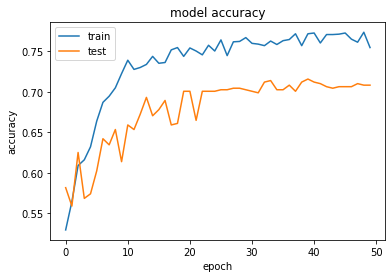

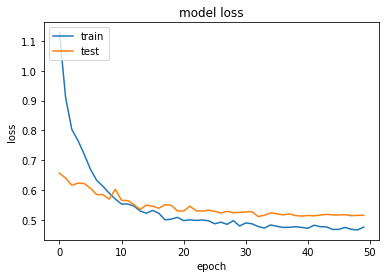

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
K.clear_session()
del model
del history

In [12]:
# Fitting model to all data
model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

model.fit(X_train, y_train, epochs=epochs, batch_size= batch_size, verbose=1, callbacks=[learning_rate_reduction])

# Testing model on test data to evaluate
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [13]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


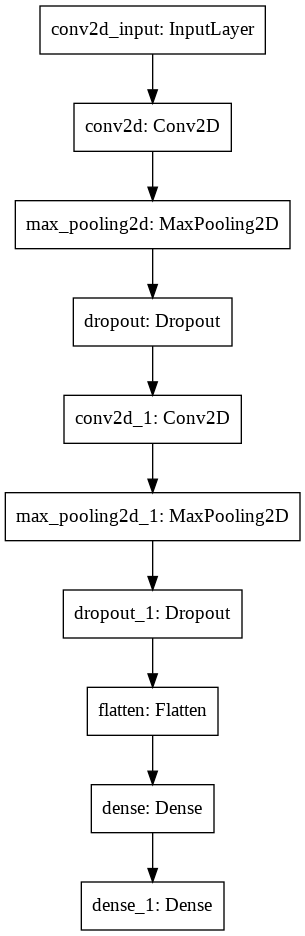

In [14]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
conf_mat = pd.DataFrame(matrix, ["Benign", "Malignant"], ["Benign", "Malignant"])
#y_pred = np.argmax(y_test, axis=1)
print('Confusion Matrix')
conf_mat

Confusion Matrix


,Benign,Malignant
Benign,291,69
Malignant,56,244
